In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
import cv2
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import optimizers
import random
from tensorflow.keras import backend
from glob import glob
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DOMAIN: Botanical Research

CONTEXT: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at
various stages of growth. They already have have invested on curating sample images. They require an automation which can create a
classifier capable of determining a plant's species from a photo.

DATA DESCRIPTION: The dataset comprises of images from 12 plant species.
Source: https://www.kaggle.com/c/plant-seedlings-classification/data.

Import and Understand the data

In [ ]:
files = glob('/content/drive/MyDrive/Colab Notebooks/PGP AIML/CV/plant-seedlings-classification/train/*/*.png')

In [ ]:
images = []
labels = []
image_name = []
for image_file in files:
  image = cv2.imread(image_file)
  labels.append(image_file.split('/')[-2])
  image_name.append(image_file.split('/')[-1])
  images.append(image)

In [ ]:
len(images)

4750

Map the images from train folder with train labels to form a DataFrame.
Unify shape of all the images

In [ ]:
IMAGE_HEIGHT = 70
IMAGE_WIDTH = 70

Ximg = np.zeros((len(images),IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for i in range(len(images)):
  img = images[i]
  img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
  Ximg[i] = np.array(img,dtype = np.float32)


Write a function that will select n random images and display images along with its species.

In [ ]:
def display_img(images, n):
  fig,ax=plt.subplots(5,1)
  fig.set_size_inches(15,15)
  for i in range(n):
      l=np.random.randint(0,len(images))
      ax[i].imshow(images[l])
      ax[i].set_title('Flower: '+labels[l])

  plt.tight_layout()

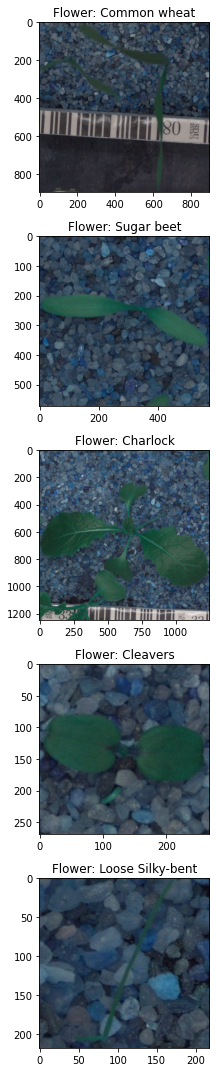

In [ ]:
display_img(images, 5)

Data preprocessing

Create X & Y

In [ ]:
Ximg = np.reshape(Ximg,(4750,70,70,3))

In [ ]:
yimg = labels

In [ ]:
np.unique(yimg, return_counts=True)

(array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
        'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
        'Scentless Mayweed', 'Shepherds Purse',
        'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25'),
 array([263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]))

In [ ]:
Ximg.shape

(4750, 70, 70, 3)

Normalise all the images

In [ ]:
Ximg = Ximg.astype('float32')/255

In [ ]:
label_encoder = LabelEncoder()
yimg = label_encoder.fit_transform(yimg)

In [ ]:
np.unique(yimg, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]))

In [ ]:
Ximg_train, Ximg_test, yimg_train, yimg_test = train_test_split(Ximg, yimg, test_size = 0.2,random_state=42)

Encode labels of the images.

In [ ]:
yimg_train = to_categorical(yimg_train)
yimg_test = to_categorical(yimg_test)

In [ ]:
print('Shape of Ximg_train: ' + str(Ximg_train.shape))
print('Shape of Ximg_test: ' + str(Ximg_test.shape))
print('Shape of yimg_train: ' + str(yimg_train.shape))
print('Shape of yimg_test: ' + str(yimg_test.shape))

Shape of Ximg_train: (3800, 70, 70, 3)
Shape of Ximg_test: (950, 70, 70, 3)
Shape of yimg_train: (3800, 12)
Shape of yimg_test: (950, 12)


Create new CNN architecture to train the model

In [ ]:
from keras import layers
model = Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (70,70,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(12,activation = 'softmax'))

In [ ]:
optrms = optimizers.RMSprop(lr = 0.0001)
model.compile(optimizer=optrms, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 68, 68, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_6 (Dense)             (None, 64)               

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train the model on train data and validate on test data

In [ ]:
history=model.fit(Ximg_train, yimg_train,
          validation_split=0.05,
          epochs=50, batch_size=64,
          verbose=1)

Train on 3610 samples, validate on 190 samples
Epoch 1/50
3610/3610 [==============================] - 2s 439us/sample - loss: 2.4054 - acc: 0.1643 - val_loss: 2.3585 - val_acc: 0.1579
Epoch 2/50
  64/3610 [..............................] - ETA: 0s - loss: 2.3584 - acc: 0.1562

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3610/3610 [==============================] - 1s 168us/sample - loss: 2.3214 - acc: 0.2158 - val_loss: 2.3021 - val_acc: 0.1947
Epoch 3/50
3610/3610 [==============================] - 1s 164us/sample - loss: 2.2192 - acc: 0.2568 - val_loss: 2.1570 - val_acc: 0.2368
Epoch 4/50
3610/3610 [==============================] - 1s 167us/sample - loss: 2.1093 - acc: 0.2947 - val_loss: 2.0957 - val_acc: 0.2789
Epoch 5/50
3610/3610 [==============================] - 1s 167us/sample - loss: 2.0025 - acc: 0.3363 - val_loss: 2.0134 - val_acc: 0.3000
Epoch 6/50
3610/3610 [==============================] - 1s 171us/sample - loss: 1.9105 - acc: 0.3632 - val_loss: 1.9228 - val_acc: 0.2895
Epoch 7/50
3610/3610 [==============================] - 1s 169us/sample - loss: 1.8209 - acc: 0.3970 - val_loss: 1.7867 - val_acc: 0.4211
Epoch 8/50
3610/3610 [==============================] - 1s 164us/sample - loss: 1.7390 - acc: 0.4186 - val_loss: 1.8071 - val_acc: 0.3632
Epoch 9/50
3610/3610 [=======================

Select a random image and print actual label and predicted label for the same

Actual label: Cleavers
Predicted label: 2


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


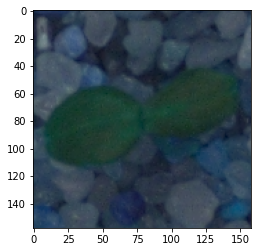

In [ ]:
l=np.random.randint(0,len(images))
plt.imshow(images[l])
img = cv2.resize(images[l], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
xpred = img.reshape(1,70,70,3).astype("float32") / 255
print('Actual label: {0}'.format(labels[l]))
print('Predicted label: {0}'.format(np.argmax(model.predict(xpred))))

The predicted label of '2' is the same as the actual category Cleavers.

DOMAIN: Botanical Research

CONTEXT: University X is currently undergoing some research involving understanding the characteristics of flowers. They already have
have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s
species from a photo.

DATA DESCRIPTION: The dataset comprises of images from 17 plant species.

In [ ]:
!pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=28b36b1e020bff2d3934afc8802a8843a300a4c2d96e473aafc4b71258560199
  Stored in directory: /root/.cache/pip/wheels/65/9b/15/cb1e6b279c14ed897530d15cfd7da8e3df8a947e593f5cfe59
Successfully built tflearn


Import and Understand the data

Import and read oxflower17 dataset from tflearn and split into X and Y while loading

In [ ]:
import tflearn as tfl
import tflearn.datasets.oxflower17 as oxflower17
X, y = oxflower17.load_data()

Instructions for updating:
non-resource variables are not supported in the long term


100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


Print Number of images and shape of the images

In [ ]:
X.shape

(1360, 224, 224, 3)

In [ ]:
print('Number of Images: ',X.shape[0])
print('Shape of images: {0}x{1}x{2}'.format( X.shape[1],X.shape[2],X.shape[3]))

Number of Images:  1360
Shape of images: 224x224x3


In [ ]:
y.shape

(1360,)

Print count of each class from y.

In [ ]:
label, counts = np.unique(y, return_counts = True)
print(np.asarray((label, counts)).T)

[[ 0 80]
 [ 1 80]
 [ 2 80]
 [ 3 80]
 [ 4 80]
 [ 5 80]
 [ 6 80]
 [ 7 80]
 [ 8 80]
 [ 9 80]
 [10 80]
 [11 80]
 [12 80]
 [13 80]
 [14 80]
 [15 80]
 [16 80]]


Image Exploration & Transformation

Display 5 random images

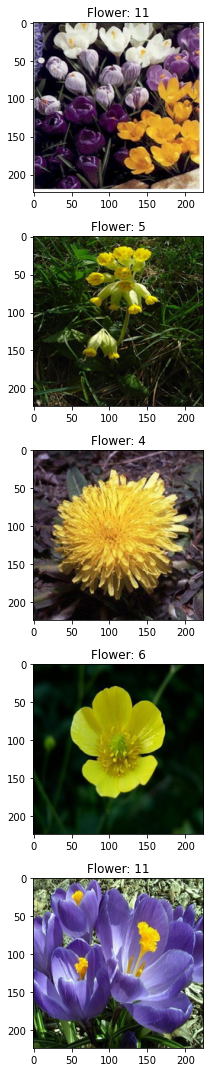

In [ ]:
fig,ax=plt.subplots(5,1)
fig.set_size_inches(15,15)
for i in range(5):
    l=np.random.randint(0,len(X))
    ax[i].imshow(X[l])
    ax[i].set_title('Flower: '+str(y[l]))

plt.tight_layout()

Select any image from the dataset and assign it to a variable

Text(0.5, 1.0, '0')

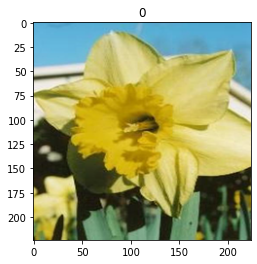

In [ ]:
a = np.random.randint(X.shape[0])
img = X[a]
plt.imshow(img)
plt.title(y[a])

Transform the image into grayscale format and display the same

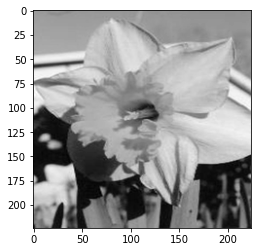

In [ ]:
gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114])
gray = gray(img)
plt.imshow(gray, cmap = plt.get_cmap(name = 'gray'))

Apply a filter to sharpen the image and display the image before and after sharpening.

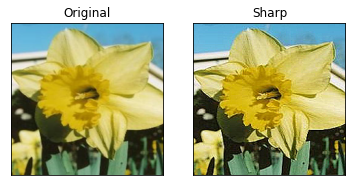

In [ ]:
from scipy.ndimage.filters import convolve
Filter = np.array([ [0, -1, 0], [-1, 5, -1], [0, -1, 0]])
Image_channel = []
for channel in range(3):
    res = convolve(img[:,:,channel], Filter)
    Image_channel.append(res)

img_sharp = np.dstack((Image_channel[0], Image_channel[1], Image_channel[2]))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_sharp),plt.title('Sharp')
plt.xticks([]), plt.yticks([])
plt.show()

Apply a filter to blur the image and display the image before and after blur.

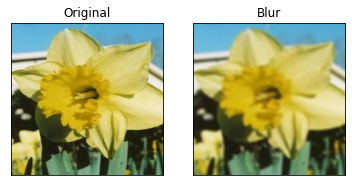

In [ ]:
Filter_Blur = cv2.blur(img,(5,5))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(Filter_Blur),plt.title('Blur')
plt.xticks([]), plt.yticks([])
plt.show()

Display all the 4 images from above questions besides each other to observe the difference

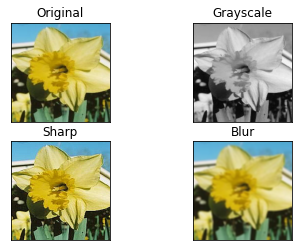

In [ ]:
plt.subplot(2,2,1),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(gray, cmap = plt.get_cmap(name = 'gray')),plt.title('Grayscale')
plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(img_sharp),plt.title('Sharp')
plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(Filter_Blur),plt.title('Blur')
plt.xticks([]), plt.yticks([])
plt.show()

Model training and Tuning

Split the data into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,random_state=42)

In [ ]:
print('Shape of X_train: ' + str(X_train.shape))
print('Shape of X_test: ' + str(X_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of X_train: (1224, 224, 224, 3)
Shape of X_test: (136, 224, 224, 3)
Shape of y_train: (1224,)
Shape of y_test: (136,)


In [ ]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [ ]:
X_flat_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
X_flat_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3])

Train a model using any Supervised Learning algorithm and share performance metrics on test data

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="liblinear")
lr.fit(X_flat_train, y_train)
lr_pred = lr.predict(X_flat_test)


print('Accuracy on Training data:',lr.score(X_flat_train, y_train) )
print('Accuracy on Test data:',lr.score(X_flat_test, y_test) )

Accuracy on Training data: 0.49019607843137253
Accuracy on Test data: 0.3088235294117647


Train a model using Neural Network and share performance metrics on test data

In [ ]:
y_train[:10]

array([ 8, 13, 11,  8,  7,  9, 10,  8, 10,  0])

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

Train a model using a Neural Network and share performance metrics on test data

In [ ]:
modeldl = Sequential()
modeldl.add(Dense(11, input_dim = X_flat_train.shape[1], kernel_initializer='he_uniform', activation = 'relu'))
modeldl.add(Dropout(0.2))
modeldl.add(BatchNormalization())
modeldl.add(Dense(y_train.shape[1], kernel_initializer='he_uniform', activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
optrms = optimizers.RMSprop(lr = 0.001)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
modeldl.compile(optimizer=optrms, loss='categorical_crossentropy', metrics=['accuracy'])
modeldl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                1655819   
                                                                 
 dropout (Dropout)           (None, 11)                0         
                                                                 
 batch_normalization (BatchN  (None, 11)               44        
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 17)                204       
                                                                 
Total params: 1,656,067
Trainable params: 1,656,045
Non-trainable params: 22
_________________________________________________________________


In [ ]:
historydl=modeldl.fit(X_flat_train, y_train,
          validation_split=0.2,
          epochs=50,
          batch_size=200,verbose=1)

Train on 979 samples, validate on 245 samples
Epoch 1/50
979/979 [==============================] - ETA: 0s - loss: 3.0009 - acc: 0.0746

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


979/979 [==============================] - 1s 2ms/sample - loss: 3.0009 - acc: 0.0746 - val_loss: 2.8466 - val_acc: 0.0571
Epoch 2/50
979/979 [==============================] - 1s 1ms/sample - loss: 2.7560 - acc: 0.1461 - val_loss: 2.8144 - val_acc: 0.0571
Epoch 3/50
979/979 [==============================] - 1s 1ms/sample - loss: 2.6769 - acc: 0.1532 - val_loss: 2.8083 - val_acc: 0.0939
Epoch 4/50
979/979 [==============================] - 1s 1ms/sample - loss: 2.6259 - acc: 0.1685 - val_loss: 2.7782 - val_acc: 0.1184
Epoch 5/50
979/979 [==============================] - 1s 1ms/sample - loss: 2.5432 - acc: 0.2033 - val_loss: 2.7986 - val_acc: 0.0571
Epoch 6/50
979/979 [==============================] - 1s 1ms/sample - loss: 2.5190 - acc: 0.2043 - val_loss: 2.8223 - val_acc: 0.1020
Epoch 7/50
979/979 [==============================] - 1s 1ms/sample - loss: 2.5339 - acc: 0.1879 - val_loss: 2.7761 - val_acc: 0.1918
Epoch 8/50
979/979 [==============================] - 1s 1ms/sample - los

In [ ]:
resultsdl = modeldl.evaluate(X_flat_test, y_test)
print('Test Loss: ',str(resultsdl[0]),'\nTest Accuracy: ',str(resultsdl[1]))

Test Loss:  2.603412530001472 
Test Accuracy:  0.15441176


Train a model using a basic CNN and share performance metrics on test data

In [ ]:
from keras import layers
modelcnn = Sequential()
modelcnn.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (224,224,3)))
modelcnn.add(layers.MaxPooling2D((2,2)))
modelcnn.add(BatchNormalization())
modelcnn.add(layers.Conv2D(64,(3,3), activation = 'relu'))
modelcnn.add(layers.MaxPooling2D((2,2)))
modelcnn.add(Dropout(0.2))
modelcnn.add(layers.Conv2D(64,(3,3), activation = 'relu'))
modelcnn.add(layers.MaxPooling2D((2,2)))
modelcnn.add(layers.Flatten())
modelcnn.add(layers.Dense(64,activation = 'relu'))
modelcnn.add(layers.Dense(y_train.shape[1],activation = 'softmax'))

In [ ]:
y_train.shape[1]

17

In [ ]:
optrms = optimizers.RMSprop(lr = 0.000001)

In [ ]:
modelcnn.compile(optimizer=optrms, loss='categorical_crossentropy', metrics=['accuracy'])
modelcnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 111, 111, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                      

In [ ]:
historycnn=modelcnn.fit(X_train, y_train,
          validation_split=0.05,
          epochs=200, batch_size = 8,
          verbose=1)

Train on 1162 samples, validate on 62 samples
Epoch 1/200
1162/1162 [==============================] - 5s 4ms/sample - loss: 2.8333 - acc: 0.0559 - val_loss: 2.8331 - val_acc: 0.1290
Epoch 2/200
1162/1162 [==============================] - 4s 3ms/sample - loss: 2.8325 - acc: 0.0620 - val_loss: 2.8330 - val_acc: 0.1129
Epoch 3/200
1162/1162 [==============================] - 4s 3ms/sample - loss: 2.8316 - acc: 0.0723 - val_loss: 2.8325 - val_acc: 0.1290
Epoch 4/200
1162/1162 [==============================] - 4s 4ms/sample - loss: 2.8305 - acc: 0.0783 - val_loss: 2.8315 - val_acc: 0.1129
Epoch 5/200
1162/1162 [==============================] - 5s 4ms/sample - loss: 2.8295 - acc: 0.0749 - val_loss: 2.8300 - val_acc: 0.0968
Epoch 6/200
1162/1162 [==============================] - 4s 3ms/sample - loss: 2.8281 - acc: 0.0706 - val_loss: 2.8284 - val_acc: 0.0968
Epoch 7/200
1162/1162 [==============================] - 4s 3ms/sample - loss: 2.8268 - acc: 0.0688 - val_loss: 2.8272 - val_acc: 0.

In [ ]:
resultscnn = modelcnn.evaluate(X_test, y_test)
print('Test Loss: ',str(resultscnn[0]),'\nTest Accuracy: ',str(resultscnn[1]))

Test Loss:  1.627580067690681 
Test Accuracy:  0.43382353


In [ ]:
ypred = modelcnn.predict(X_test)


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label

In [ ]:
imgpred = cv2.imread('Prediction-Flower.jpg')

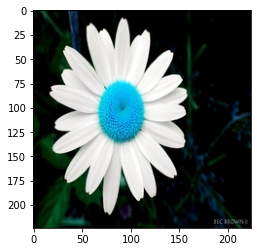

In [ ]:
plt.imshow(imgpred)

In [ ]:
imgpred = imgpred.reshape(1,224,224,3).astype("float32") / 255

In [ ]:
imgpred.shape

(1, 224, 224, 3)

In [ ]:
y_pred = modelcnn.predict(imgpred)
print('Predicted category of the flower: {0}'.format(np.argmax(y_pred, axis=1)))

Predicted category of the flower: [7]


In [ ]:
%%shell
jupyter nbconvert --to html /content/CV.ipynb

[NbConvertApp] Converting notebook /content/CV.ipynb to html
[NbConvertApp] Writing 1997338 bytes to /content/CV.html
